# Fashion MNIST project - classifing clothing pictures

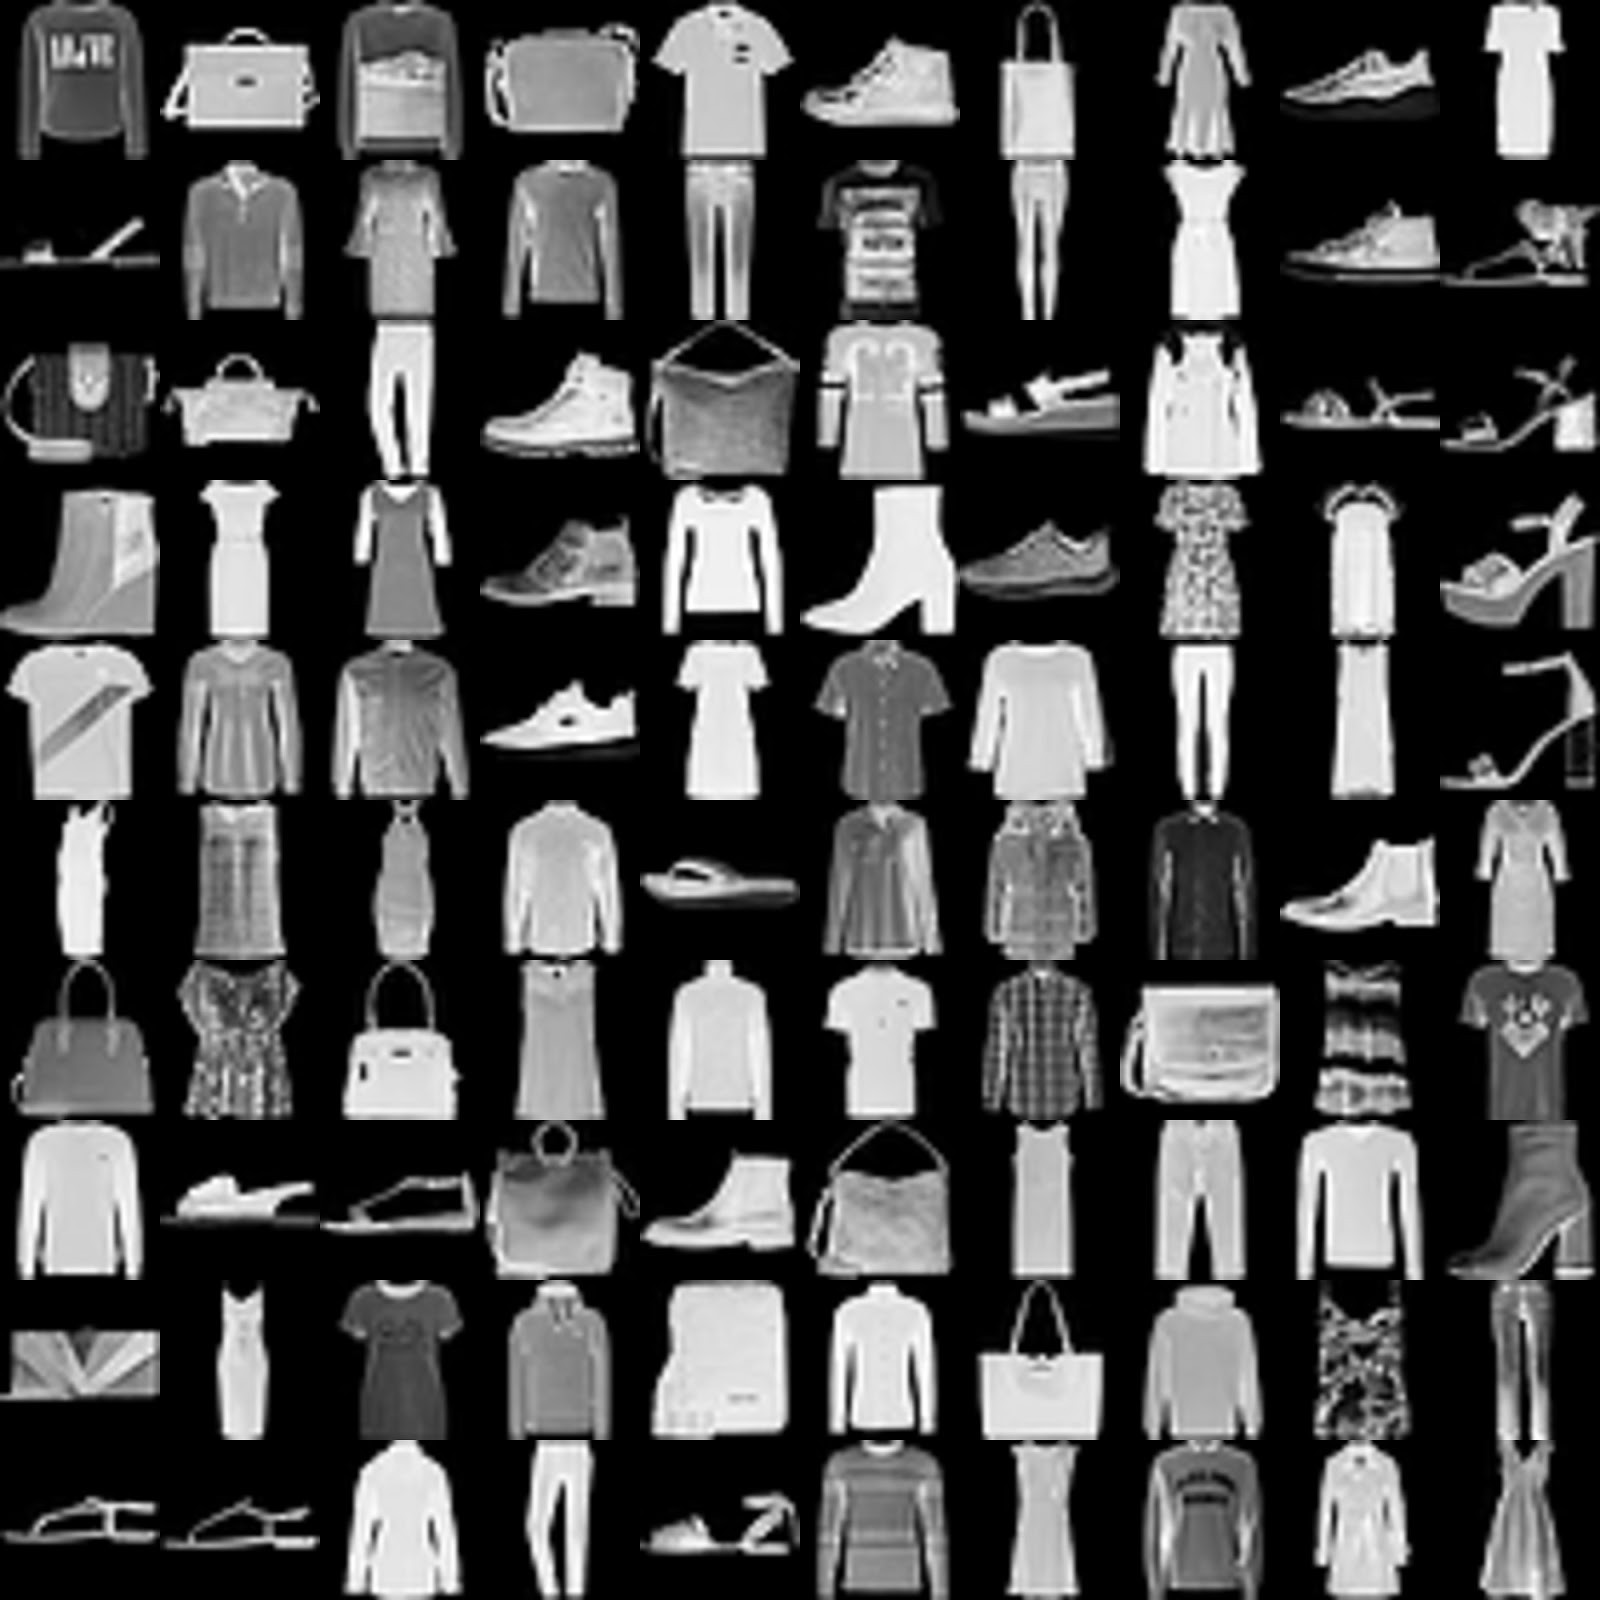

In this project we were asked to take the Fashion MNIST data set and to try to give the best prediction based on the models we learned in class.

### Table of Contents:
    1. Getting to know the data, train test split, pca.
    2. Sampling models:
        a. knn classifier + grid search
        b. random forest classifier
        c. naive bays
        d. logistic regression
        e. adaboost
    3. comparing models scores and choosing the final model

## Getting to know the data, train test split, pca:

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import tensorflow.keras as tk
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
fashion_mnist = tk.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
x_train = np.reshape(X_train_full, (60000, 28*28))

In [4]:
x_train = x_train/255

In [5]:
x_train.shape

(60000, 784)

After making the intial transormation to the data, we wanted to reduce the number of dimention in each picture. Thus, we used PCA.

In [6]:
pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x_train)

In [26]:
x_reduced.shape

(60000, 187)

As we can see, the number of the pixels in each photo dropped to 187! By preserving only 95% of the variance, the number of features dropped to about quarter of the original number of features.

## Sampling models:
### a. knn classifier + grid search
Knn is a model that searches by given parameters the closest n neighbors of an item

Text(0, 0.5, 'Testing Accuracy')

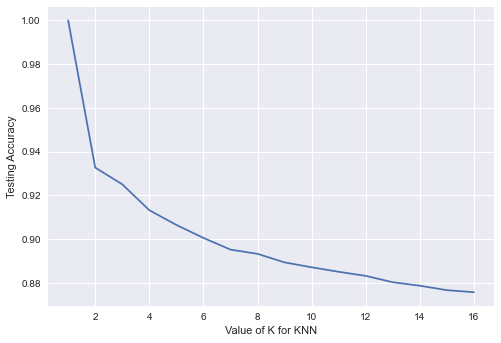

In [7]:
k_range = list(range(1, 17))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_reduced, y_train_full)
    pred = knn.predict(x_reduced)
    scores.append(metrics.accuracy_score(y_train_full, pred))
    
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

K=1 would be over-fitting and k=2 won't be good (if there are 2 neighbors and each one says something different, it would be hard to decide).
Thus, it seems that the best choice is k=3.
To be sure, we'll do another check, this time- using KFold and checking the mean score of each k and its std.

In [9]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [10]:
k_range = list(range(1, 17))
k_mean_scores = []
k_std_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_reduced, y_train_full, cv=kf, scoring='accuracy')
    k_mean_scores.append(scores.mean())
    k_std_scores.append(scores.std())

d = {'k_mean': k_mean_scores, 'k_std': k_std_scores}
Ks = pd.DataFrame(data = d, index=k_range)

In [11]:
Ks['k_mean'].sort_values(ascending=False).head(10)

6     0.866733
8     0.865183
4     0.865167
5     0.863983
7     0.863750
9     0.863650
10    0.863383
12    0.862267
11    0.862117
3     0.861633
Name: k_mean, dtype: float64

In [12]:
Ks['k_std'].sort_values(ascending=True)

14    0.003441
16    0.003443
6     0.003763
11    0.003830
15    0.003982
12    0.004021
8     0.004113
3     0.004155
13    0.004224
2     0.004372
7     0.004402
9     0.004675
5     0.004719
10    0.004799
1     0.004996
4     0.005290
Name: k_std, dtype: float64

we'll see that we can't be sure which k is the best to take, so we'll try to decide by doing Grid search

In [13]:
knn=KNeighborsClassifier()
k_range = list(range(3,17,2))
print(k_range)
weight_options = ['uniform', 'distance']
metrics_options = ['euclidean', 'manhattan']
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metrics_options)
grid=GridSearchCV(knn, param_grid, cv=kf, scoring='accuracy')
print("getting to fit")
grid.fit(x_reduced, y_train_full)
print(grid.best_score_)
print(grid.best_params_)

[3, 5, 7, 9, 11, 13, 15]
getting to fit
0.8693166666666666
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


As we can see from the GridSearch, the best k to choose is k=5

In [14]:
our_best_knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance')

### b. Random Forest Classifier
Random forest classifier is a model that creates a couple of binary trees, trying with the data set that has been given a random few of them and chooses the one that performed best.

In [15]:
random_for = RandomForestClassifier()
randomfor_score = cross_val_score(random_for, x_reduced, y_train_full, cv=kf, scoring='accuracy').mean()
print(randomfor_score)

0.8654


### c. Naive Bayes
Naive Bayes is a model that assumes that there is no connection between the features, and then tries to predict.

In [16]:
naive_bay = GaussianNB()
bayes_score = cross_val_score(naive_bay, x_reduced, y_train_full, cv=kf, scoring='accuracy').mean()
print(bayes_score)

0.7488666666666667


### d. Logistic Regression
Logistic Regression is a model that classifies by defining a line between each one of the classes

In [17]:
logis_reg = LogisticRegression(max_iter=2000, multi_class='multinomial')
reg_score = cross_val_score(logis_reg, x_reduced, y_train_full, cv=kf, scoring='accuracy').mean()
print(reg_score)

0.8579166666666665


### e. Adaboost
Adaboost is a model that uses another model as it's base, and make a couple predictions in a row, by correcting itself each time.

In [20]:
adac = AdaBoostClassifier(base_estimator=random_for, n_estimators=200, learning_rate=1.0, algorithm='SAMME.R', random_state=42)
adac.fit(x_reduced, y_train_full)
adac_score = cross_val_score(adac, x_reduced, y_train_full, cv=kf, scoring='accuracy').mean()
print(adac_score)

0.8653000000000001


### We can see that the KNN model gives us the best results(86.9%). Thus, we chose it to be our final model.

## Apllying the  testing on the model

pipeline function:

In [21]:
def get_data_ready(data):
    re_data = np.reshape(data, (len(data), 28*28))
    re_data = re_data/255
    final_data = pca.transform(re_data)
    return final_data

In [22]:
test = get_data_ready(X_test)

In [25]:
our_best_knn.fit(x_reduced, y_train_full)
final_predict = our_best_knn.predict(test)
print('Final accuracy score of model is: ', accuracy_score(y_test,final_predict))

Final accuracy score of model is:  0.8685
